# CNN to classify cats/dogs

In [1]:
import matplotlib.pyplot as plt
import os
import random

# The Cats and Dogs dataset

Taking a look at the data:

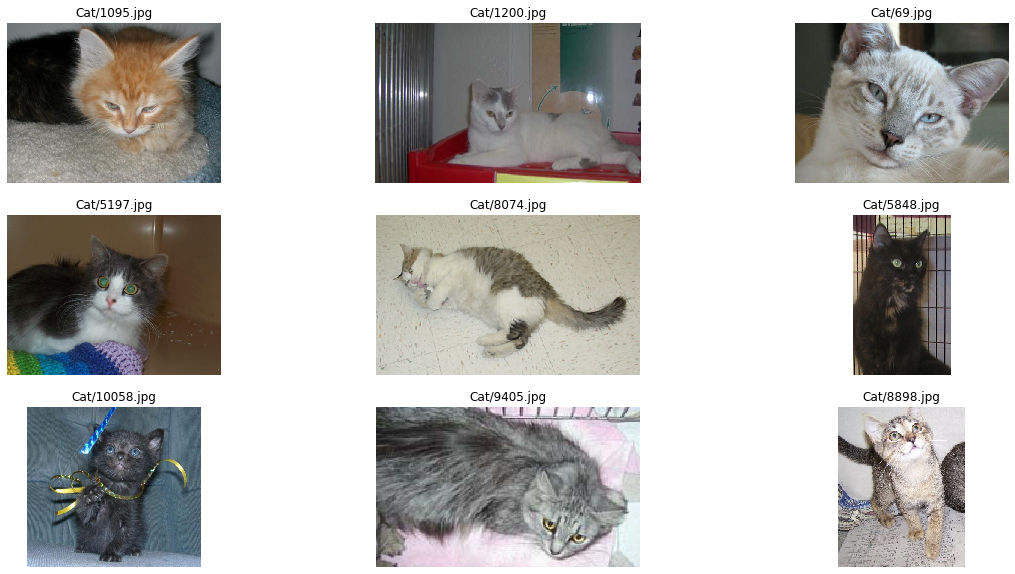

In [17]:
src = 'Dataset/PetImages/'

# Get list of file names
_, _,cat_images = next(os.walk('Dataset/PetImages/Cat'))

# Prepare a 3x3 plot (total of 9 images)
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('Dataset/PetImages/Cat/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)

plt.show()

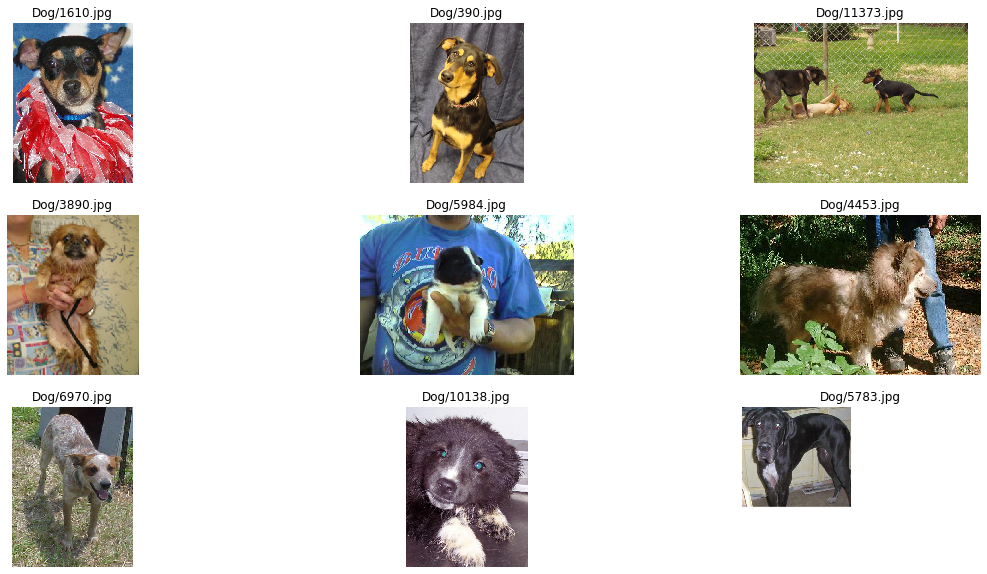

In [3]:
# Get list of file names
_, _, dog_images = next(os.walk('Dataset/PetImages/Dog'))

# Prepare a 3x3 plot (total of 9 images)
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('Dataset/PetImages/Dog/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/'+img)

plt.show()

Some observations from the data:
    - The images have different dimensions
    - The subjects are mostly centered in the image
    - The subjects have different orientations

## Train/test split

Here I am splitting the data into train/test folders for each class: cat/dog:

In [9]:
from utils import train_test_split

src_folder = 'Dataset/PetImages/'
train_test_split(src_folder)

## Image augmentation

Before I begin building the CNN, I am going to perform some image augmentation techniques, which are important for any image classification project. Image augmentation is the creation of aditional training data by making minor alterations to the images. Some alterations include:

- Image translation
- Image rotation
- Horizontal flip
- Zooming into the image

In [5]:
#Keras provides a handy class to facilitate image augmentation
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range = 30,
                                    width_shift_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

Using TensorFlow backend.


6983.jpg


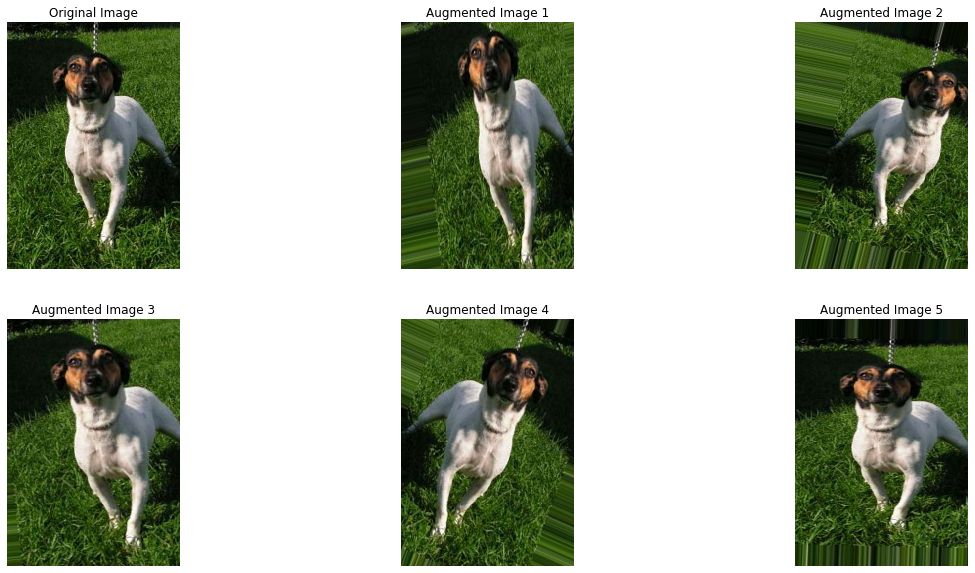

In [6]:
# Let's use it to augment a randomly selected image from /Train/Dog:
fig, ax = plt.subplots(2,3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk('Dataset/PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
print(random_img)
random_img = plt.imread('Dataset/PetImages/Train/Dog/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else:
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))


plt.show()

# Model Building

## Building a Simple CNN

The architecture of the model will consist of :

input --> Convolution & pooling Layers --> Fully Connected Layers --> Output

The convolution and pooling layers are responsible for learning the spatial characteristics of the classes, while the fully connected layers learn to make predictions using these characteristics.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()

In [8]:
# Declaring values for hyperparameters:
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE  = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 10

In [9]:
# Add first convolutional layer with 32 filters, each of size (3x3)
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), input_shape = (INPUT_SIZE, INPUT_SIZE, 3), activation = 'relu'))
# Add max pooling layer
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))
# Add a second one
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))

# Flatten the output from convolution layers
model.add(Flatten())
# Add a fully connected layer with 128 nodes
model.add(Dense(units = 128, activation = 'relu'))
# Add dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Add one last fully connected layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [10]:
# Compile the model
# loss function is binary_crossentropy since we are doing a binary classification
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
# Using ImageDataGenerator and flow_from_directory methods to train the model in real time, which loads batches of
# the dataset into memory only as required:

training_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory(src+'Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.
Epoch 1/10
1250/1250 [==============================] - 116s 93ms/step - loss: 0.6393 - accuracy: 0.6215
Epoch 2/10
1250/1250 [==============================] - 68s 54ms/step - loss: 0.5361 - accuracy: 0.7296
Epoch 3/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.4910 - accuracy: 0.7651
Epoch 4/10
1250/1250 [==============================] - 69s 55ms/step - loss: 0.4554 - accuracy: 0.7863
Epoch 5/10
1250/1250 [==============================] - 69s 55ms/step - loss: 0.4295 - accuracy: 0.8024
Epoch 6/10
1250/1250 [==============================] - 68s 54ms/step - loss: 0.4045 - accuracy: 0.8152
Epoch 7/10
1250/1250 [==============================] - 68s 54ms/step - loss: 0.3779 - accuracy: 0.8285
Epoch 8/10
1250/1250 [==============================] - 67s 53ms/step - loss: 0.3540 - accuracy: 0.8421
Epoch 9/10
1250/1250 [==============================] - 66s 53ms/step - loss: 0.3401 - accuracy: 0.8506
Epoch 10/10
1250/125

Now, evaluate the model on the testing set:

In [13]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory(src+'Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

score = model.evaluate_generator(test_set, steps=100)

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

Found 5000 images belonging to 2 classes.
loss: 0.6533731818199158
accuracy: 0.78125


### The model is 78% accurate

## Making the model better

We can obtain better performance by leveraging on transfer learning. In the context of CNN, transfer learning
involves freezing the convolution-pooling layers, and only retraining the final fully connected layers.

I will be suing the VGG16 model to make predictions on my dataset of cats and dogs. The VGG16 model was developed to for the ILSVRC, which required the model to make a 1,000 class multiclass classification. Among those classes are specific breeds of cats and dogs.

In [28]:
from keras.applications.vgg16 import VGG16

INPUT_SIZE = 128
# include_top=False tells keras not to import the fully connected layers at the end of the VGG16 network
vgg16 = VGG16(include_top=False, weights='imagenet',
             input_shape=(INPUT_SIZE,INPUT_SIZE,3))

# Now freeze the layers in the VGG16 model, since we won't retrain them from scratch:
for layer in vgg16.layers:
    layer.trainable = False

In [29]:
# Next we are going to add a fully connected layer with one node at the end of the NN.
# The syntax is different because VGG16 is not a keras Sequential model

from keras.models import Model

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

/Users/rosagradilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [30]:
# Define hyperparameters

BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory(src+'Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

test_set = testing_data_generator.flow_from_directory(src+'Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 339s 2s/step - loss: 0.3832 - accuracy: 0.8306
Epoch 2/3
200/200 [==============================] - 335s 2s/step - loss: 0.2884 - accuracy: 0.8733
Epoch 3/3
200/200 [==============================] - 323s 2s/step - loss: 0.2741 - accuracy: 0.8897


#### Evaluate the model on the testing set:

In [32]:
score = model.evaluate_generator(test_set, steps=100)

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

loss: 0.1436326503753662
accuracy: 0.8862500190734863


The pretrained model bumped up testing accuracy quite a bit.

## Results analysis

Let's take a look at our results, in particular the kind of images the CNN does well in, and what kind of images it gets wrong.

Recall that the output of the sigmoid activation function is a list of values bewteen 0 and 1. Therefore, an output of 0.5 means that the model isn't so sure, while an output close to 0 or 1 means the model is very sure about its predictions.

Let's run through the images in the testing set one by one, using the model to make predictions on the class of the image, and classify the images according to three categories:

- Strongly right predictions: the model predicted correctly and the output value is > 0.8 or < 0.2
- Strongly wrong predictions: the model predicted wrongly, and the output value is >0.8 or <0.2
- Weakly wrong predictions: The model predicted wrongly, output is between 0.4 and 0.6